<a href="https://colab.research.google.com/github/malcolmlett/robovac/blob/main/Experiment_FloorPlan_to_LDS_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FloorPlan to LDS v2
Proves out that I can do the same thing via code from github.

In [95]:
import os
if os.path.isdir('repo'):
  # discard any local changes and update
  !cd repo && git reset --hard HEAD
  !cd repo && git pull
else:
  !git clone https://github.com/malcolmlett/robovac.git repo
from repo import lds
from importlib import reload
reload(lds)

HEAD is now at 7ee78dc Automatically compute a sensible step size
Already up to date.


<module 'repo.lds' from '/content/repo/lds.py'>

In [ ]:
!pip install -Uqq ipdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 30.8 MB/s eta 0:00:00


In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import requests
import math
import ipdb
from timeit import default_timer as timer
from repo import lds
from importlib import reload
reload(lds)

<module 'repo.lds' from '/content/repo/lds.py'>

In [ ]:
# Load single black'n'white image as source data from github
floorplan = Image.open('repo/data/experimental-floorplan1.png')
floorplan = np.array(floorplan, dtype=np.bool_)
floorplan.shape

(84, 94)

points: (3600, 2)


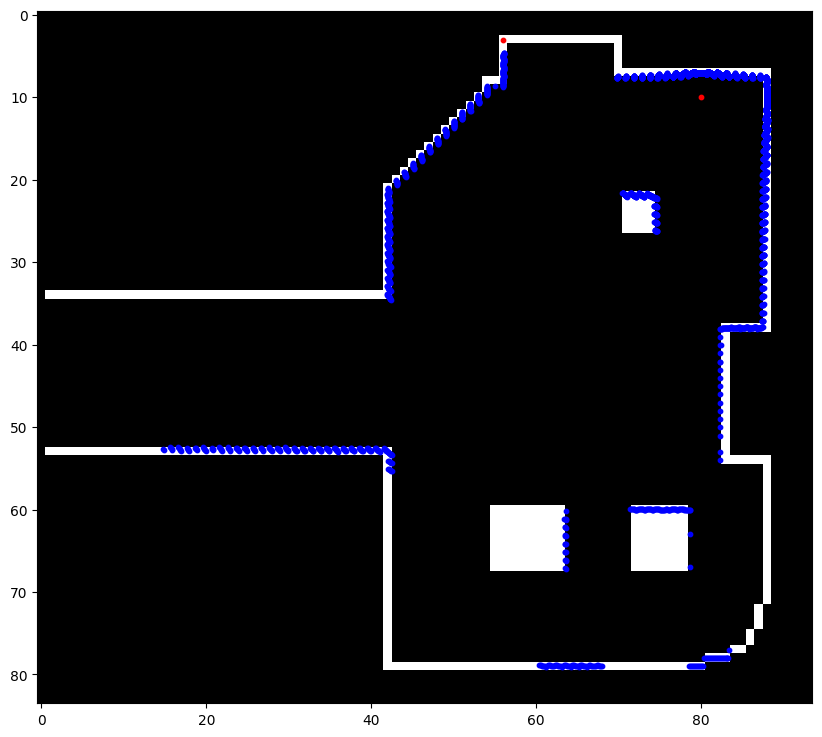

In [ ]:
# Plot lds data
# (note that pixels span +/- 0.5 either side of their integer positions)
loc = (80, 10)
points = lds.lds_to_2d(lds.lds_sample(floorplan, loc, 0.0, pixel_size=1, resolution=math.pi/180*0.1), loc, 0.0)
print(f"points: {points.shape}")
plt.figure(figsize=(10, 10))
plt.imshow(floorplan, cmap='gray')
#for x, y in points:
#  plt.plot([loc[0], x], [loc[1], y], color='grey', linewidth=0.5)
plt.scatter(loc[0], loc[1], c='r', s=10)
plt.scatter(56, 3, c='r', s=10)
plt.scatter(points[:,0], points[:,1], c='b', s=10)
plt.show()

## Pixel Sizings
We'll need to work with conversions between pixels and physical units. So let's check that out.

Let's say that our current floor plan spans about 5m on the vertical axis, across its 73 pixels. Thats 6.8cm/px.
We also know that the LDS unit has a max range of 3.5m. So let's try the same thing with physical coordinates.

loc: [80. 10.]
ranges: (360,) - 2.9231101943557056-76.27466192020974
points: (360, 2) - (16.76543943421285,4.903023927196895)-(88.07553522741537,79.01536377163389)


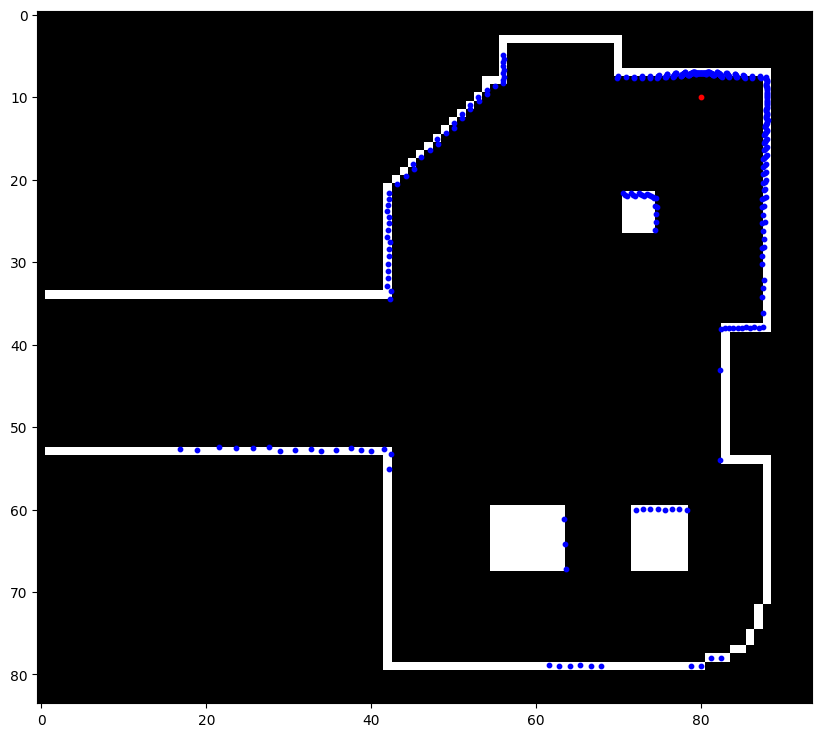

In [58]:
reload(lds)
pixel_size = 1.0
loc = np.array([80.0, 10.0]) * pixel_size
print(f"loc: {loc}")
ranges = lds.lds_sample(floorplan, loc, 0.0, pixel_size=pixel_size, max_distance=100, step_size=5)
print(f"ranges: {ranges.shape} - {np.nanmin(ranges)}-{np.nanmax(ranges)}")
points = lds.lds_to_2d(ranges, loc, 0.0)
print(f"points: {points.shape} - ({np.min(points[:,0])},{np.min(points[:,1])})-({np.max(points[:,0])},{np.max(points[:,1])})")
plt.figure(figsize=(10, 10))
plt.imshow(floorplan, cmap='gray')
plt.scatter(loc[0]/pixel_size, loc[1]/pixel_size, c='r', s=10)
plt.scatter(points[:,0]/pixel_size, points[:,1]/pixel_size, c='b', s=10)

loc: [544.  68.]
ranges: (360,) - 19.877149321618795-344.3240707005354
points: (330, 2) - (285.0977723264948,33.3405627049389)-(598.9136395464245,408.0848700171747)


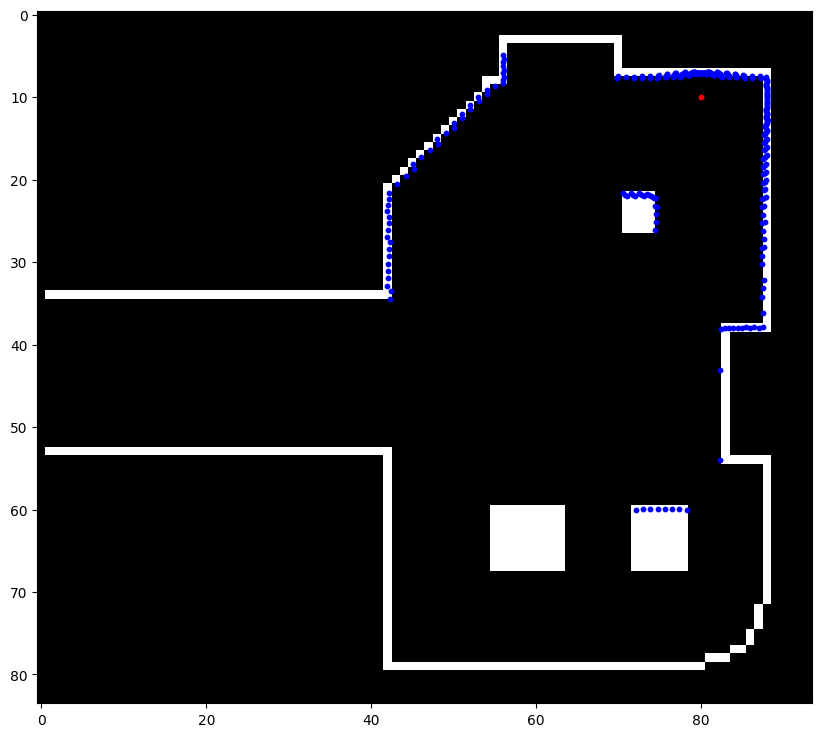

In [57]:
reload(lds)
#pixel_size = 6.8/100.0  # metres
#max_distance = 3.5 # metres
pixel_size = 6.8  # cm
max_distance = 350 # cm
loc = np.array([80.0, 10.0]) * pixel_size
print(f"loc: {loc}")
ranges = lds.lds_sample(floorplan, loc, 0.0, pixel_size=pixel_size, max_distance=max_distance, step_size=max_distance/10)
print(f"ranges: {ranges.shape} - {np.nanmin(ranges)}-{np.nanmax(ranges)}")
points = lds.lds_to_2d(ranges, loc, 0.0)
print(f"points: {points.shape} - ({np.min(points[:,0])},{np.min(points[:,1])})-({np.max(points[:,0])},{np.max(points[:,1])})")
plt.figure(figsize=(10, 10))
plt.imshow(floorplan, cmap='gray')
plt.scatter(loc[0]/pixel_size, loc[1]/pixel_size, c='r', s=10)
plt.scatter(points[:,0]/pixel_size, points[:,1]/pixel_size, c='b', s=10)

## Performance
Let's quickly sanity check to find a suitable approach for heuristically picking a step_size.

Note that our input image is quite low res and only 84x94px, so we can't go to anything finer-grained than 50 steps (leads to div-by-zero error if you try because the floor() on the grid size calculation generates a zero-sized grid-cell).

In [83]:
reload(lds)
pixel_size = 6.8  # cm
max_distance = 350 # cm
loc = np.array([80.0, 10.0]) * pixel_size

# warm-up
for i in range(20):
  ranges = lds.lds_sample(floorplan, loc, 0.0, pixel_size=pixel_size, max_distance=max_distance, step_size=max_distance/3)

# run test
for steps in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 50]:
  start = timer()
  for i in range(10):
    ranges = lds.lds_sample(floorplan, loc, 0.0, pixel_size=pixel_size, max_distance=max_distance, step_size=max_distance/steps)
  duration = (timer() - start)*1000
  print(f"{steps} steps: {duration} ms")


1 steps: 261.92407899998216 ms
2 steps: 349.3158849996689 ms
3 steps: 375.7719269997324 ms
4 steps: 439.389877999929 ms
5 steps: 480.7005760003449 ms
6 steps: 555.2663819998997 ms
7 steps: 656.8078350001088 ms
8 steps: 1013.7596499998835 ms
9 steps: 1070.311629000571 ms
10 steps: 1212.3267050001232 ms
20 steps: 2076.739008000004 ms
50 steps: 6264.231708999432 ms


Well that's dissappointing, consisently 1-step is the most performant, with it getting progressively slower as the number of steps go up.

But this is with a very low-res image. So I've picked a default of 3 steps.

Let's check that the default gets similar performance:

In [96]:
reload(lds)

# warm-up
for i in range(20):
  ranges = lds.lds_sample(floorplan, loc, 0.0, pixel_size=pixel_size, max_distance=max_distance)

# run test
start = timer()
for i in range(10):
  ranges = lds.lds_sample(floorplan, loc, 0.0, pixel_size=pixel_size, max_distance=max_distance)
duration = (timer() - start)*1000
print(f"default steps: {duration} ms")


default steps: 367.83995399946434 ms


And let's check that it works:

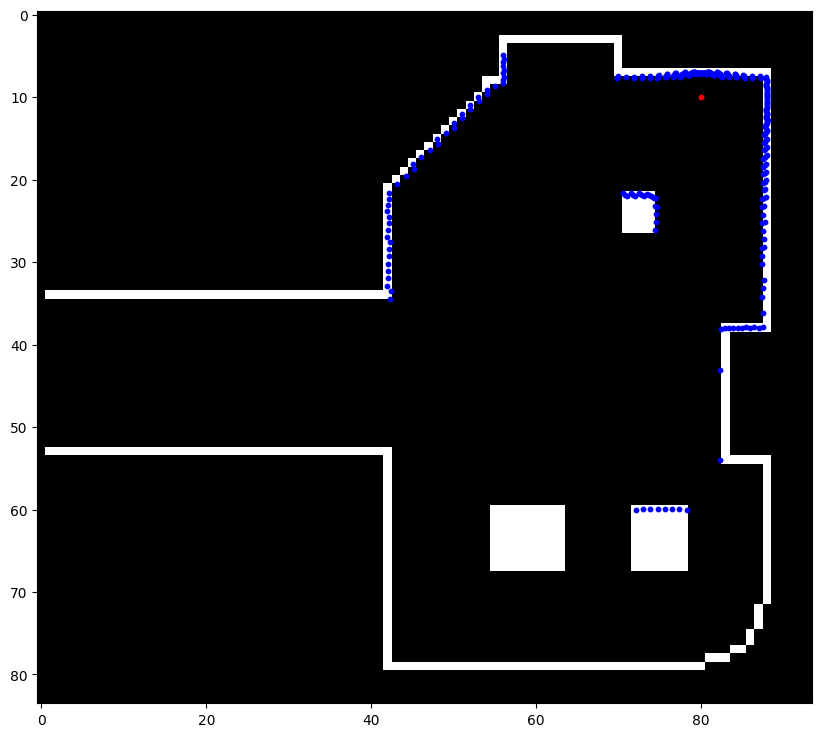

In [97]:
#pixel_size = 6.8/100.0  # metres
#max_distance = 3.5 # metres
pixel_size = 6.8  # cm
max_distance = 350 # cm
loc = np.array([80.0, 10.0]) * pixel_size
ranges = lds.lds_sample(floorplan, loc, 0.0, pixel_size=pixel_size, max_distance=max_distance)
points = lds.lds_to_2d(ranges, loc, 0.0)
plt.figure(figsize=(10, 10))
plt.imshow(floorplan, cmap='gray')
plt.scatter(loc[0]/pixel_size, loc[1]/pixel_size, c='r', s=10)
plt.scatter(points[:,0]/pixel_size, points[:,1]/pixel_size, c='b', s=10)

In [70]:
[1/5, 1.]


[0.2, 1.0]